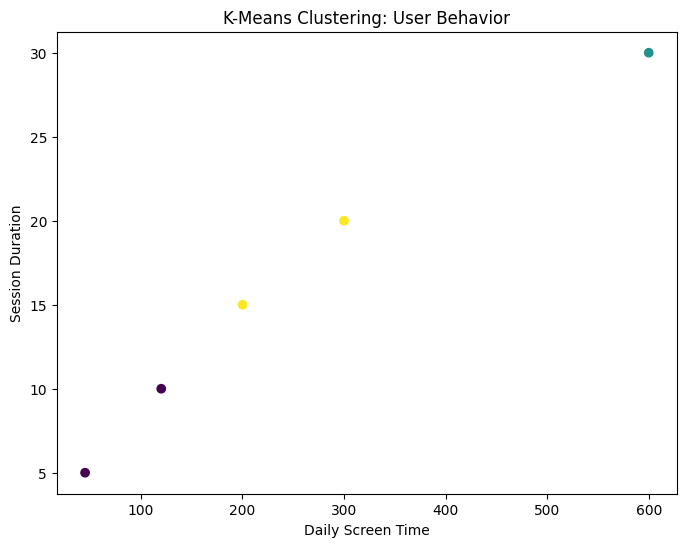

,user_id,cluster
0,1,0
1,2,0
2,3,2
3,4,1
4,5,2


In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("../preprocessing/sample_dataset.csv")

# Select relevant features for clustering
features = df[['daily_screen_time', 'session_duration', 'app_switches', 'night_activity']]

# Normalize the data (important for KMeans)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(features_scaled)

# Plotting the clusters for visual inspection
plt.figure(figsize=(8, 6))
plt.scatter(df['daily_screen_time'], df['session_duration'], c=df['cluster'], cmap='viridis')
plt.xlabel('Daily Screen Time')
plt.ylabel('Session Duration')
plt.title('K-Means Clustering: User Behavior')
plt.show()

# Show the resulting dataframe
display(df[['user_id', 'cluster']])
